## Inisialisasi Spark Session

In [1]:
from pyspark.sql import SparkSession

# Membuat Spark session
spark = SparkSession.builder \
    .appName("Flora Sumatera") \
    .getOrCreate()

## Visualisasi Peta Sebaran Flora di Sumatera

Index(['featurecla', 'scalerank', 'adm1_code', 'diss_me', 'iso_3166_2',
       'wikipedia', 'iso_a2', 'adm0_sr', 'name', 'name_alt',
       ...
       'FCLASS_ID', 'FCLASS_PL', 'FCLASS_GR', 'FCLASS_IT', 'FCLASS_NL',
       'FCLASS_SE', 'FCLASS_BD', 'FCLASS_UA', 'FCLASS_TLC', 'geometry'],
      dtype='object', length=122)
['Western Australia' 'Northern Territory' 'South Australia' 'Queensland'
 'Tasmania' 'Victoria' 'Australian Capital Territory'
 'Jervis Bay Territory' 'New South Wales' 'Acre' 'Rondônia' 'Roraima'
 'Amazonas' 'Pará' 'Mato Grosso do Sul' 'Amapá' 'Mato Grosso' 'Paraná'
 'Distrito Federal' 'Goiás' 'Tocantins' 'São Paulo' 'Maranhão'
 'Rio de Janeiro' 'Piauí' 'Minas Gerais' 'Espírito Santo' 'Bahia' 'Ceará'
 'Sergipe' 'Alagoas' 'Rio Grande do Norte' 'Pernambuco' 'Paraíba'
 'Santa Catarina' 'Rio Grande do Sul' 'Alberta' 'British Columbia'
 'Manitoba' 'New Brunswick' 'Newfoundland and Labrador' 'Nova Scotia'
 'Northwest Territories' 'Nunavut' 'Ontario' 'Prince Edward Island'
 

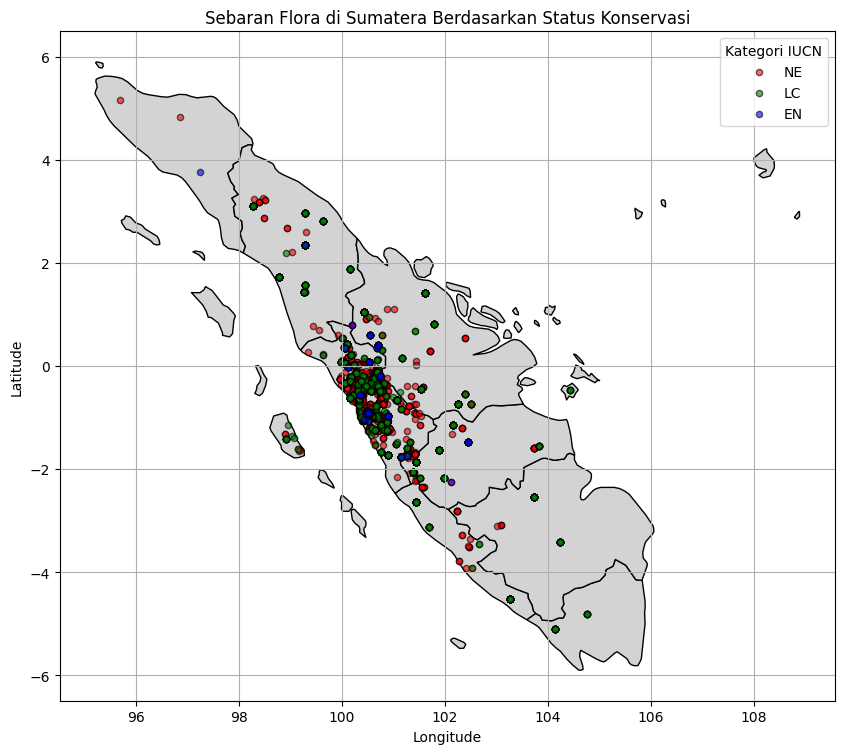

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load shapefile Natural Earth level provinsi (admin 1)
provinsi = gpd.read_file('/content/ne_50m_admin_1_states_provinces.shp')

# 2. Filter provinsi Sumatera (nama provinsi biasanya di kolom 'name' atau 'name_en')
prov_sumatera = [
    'Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Jambi',
    'Sumatera Selatan', 'Bengkulu', 'Lampung', 'Kepulauan Riau'
]

# Cek nama kolom nama provinsi dulu, contoh:
print(provinsi.columns)
print(provinsi['name'].unique())  # atau 'name_en'

# Filter provinsi Sumatera
sumatera = provinsi[provinsi['name'].isin(prov_sumatera)]

# 3. Load data flora
df = pd.read_excel('/content/gbif_occurrence_full.xlsx')

# Drop baris tanpa koordinat dan kategori IUCN
df = df.dropna(subset=['decimalLatitude', 'decimalLongitude', 'iucnRedListCategory'])

# 4. Buat GeoDataFrame flora
from shapely.geometry import Point
geometry = [Point(xy) for xy in zip(df['decimalLongitude'], df['decimalLatitude'])]
gdf_flora = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# 5. Filter titik flora yang ada di wilayah Sumatera dengan spatial join
gdf_flora_sumatera = gpd.sjoin(gdf_flora, sumatera, how='inner', predicate='within')

# 6. Plot peta
fig, ax = plt.subplots(figsize=(10, 12))
sumatera.plot(ax=ax, color='lightgray', edgecolor='black')

# 7. Plot titik flora berdasarkan kategori konservasi
colors = {'NE': 'red', 'LC': 'green', 'EN': 'blue'}

for category, color in colors.items():
    subset = gdf_flora_sumatera[gdf_flora_sumatera['iucnRedListCategory'] == category]
    subset.plot(ax=ax, marker='o', color=color, markersize=20, label=category, alpha=0.6, edgecolor='k')

plt.title('Sebaran Flora di Sumatera Berdasarkan Status Konservasi')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Kategori IUCN')
plt.grid(True)
plt.show()


## Visualisasi Peta Sebaran Flora di Sumatera dengan Keterangan Provinsi

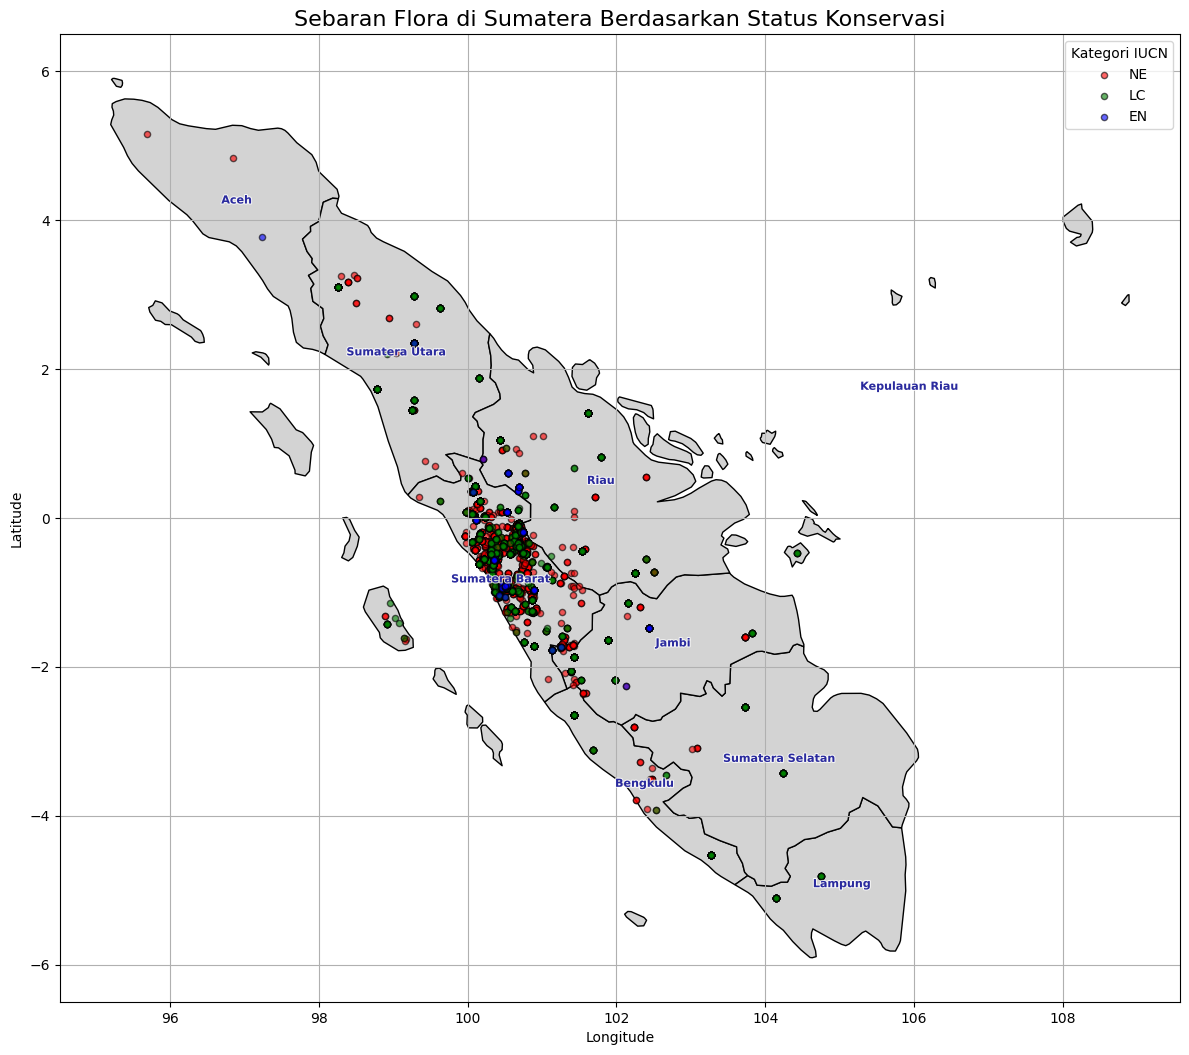

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from shapely.geometry import Point

# 1. Load shapefile Natural Earth level provinsi (admin 1)
provinsi = gpd.read_file('/content/ne_50m_admin_1_states_provinces.shp')

# 2. Filter provinsi Sumatera
prov_sumatera = [
    'Aceh', 'Sumatera Utara', 'Sumatera Barat', 'Riau', 'Jambi',
    'Sumatera Selatan', 'Bengkulu', 'Lampung', 'Kepulauan Riau'
]
sumatera = provinsi[provinsi['name'].isin(prov_sumatera)]

# 3. Load data flora
df = pd.read_excel('/content/gbif_occurrence_full.xlsx')
df = df.dropna(subset=['decimalLatitude', 'decimalLongitude', 'iucnRedListCategory'])

# 4. Buat GeoDataFrame flora
geometry = [Point(xy) for xy in zip(df['decimalLongitude'], df['decimalLatitude'])]
gdf_flora = gpd.GeoDataFrame(df, geometry=geometry, crs='EPSG:4326')

# 5. Spatial join: flora di Sumatera
gdf_flora_sumatera = gpd.sjoin(gdf_flora, sumatera, how='inner', predicate='within')

# 6. Plot peta
fig, ax = plt.subplots(figsize=(12, 14))
sumatera.plot(ax=ax, color='lightgray', edgecolor='black')

# 7. Plot titik flora
colors = {'NE': 'red', 'LC': 'green', 'EN': 'blue'}

for category, color in colors.items():
    subset = gdf_flora_sumatera[gdf_flora_sumatera['iucnRedListCategory'] == category]
    subset.plot(ax=ax, marker='o', color=color, markersize=20, label=category, alpha=0.6, edgecolor='k')

# 8. Label provinsi (diperkecil dan lebih transparan)
for idx, row in sumatera.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, row['name'],
            fontsize=8, fontweight='bold',
            ha='center', va='center',
            color='darkblue', alpha=0.8,
            path_effects=[path_effects.withStroke(linewidth=1.5, foreground="white")])

# 9. Finalisasi
plt.title('Sebaran Flora di Sumatera Berdasarkan Status Konservasi', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Kategori IUCN')
plt.grid(True)
plt.tight_layout()
plt.show()
